## 必要なパッケージのインポート

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

## データセットの読み込み

In [31]:
diabetes = load_diabetes()
data = diabetes.data  # data
label = diabetes.target  # labels
label_names = diabetes.feature_names



## データセットの中身を確認

In [32]:
# データセットのデータを確認
print('+++ diabetes data +++')
print(data)

# データセットの正解ラベルを確認
print('+++ diabetes label +++')
print(label)

# データセットの正解ラベルの名前を確認
print('+++ diabetes label names +++')
print(label_names)


+++ diabetes data +++
[[ 0.03807591  0.05068012  0.06169621 ... -0.00259226  0.01990749
  -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 ... -0.03949338 -0.06833155
  -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 ... -0.00259226  0.00286131
  -0.02593034]
 ...
 [ 0.04170844  0.05068012 -0.01590626 ... -0.01107952 -0.04688253
   0.01549073]
 [-0.04547248 -0.04464164  0.03906215 ...  0.02655962  0.04452873
  -0.02593034]
 [-0.04547248 -0.04464164 -0.0730303  ... -0.03949338 -0.00422151
   0.00306441]]
+++ diabetes label +++
[151.  75. 141. 206. 135.  97. 138.  63. 110. 310. 101.  69. 179. 185.
 118. 171. 166. 144.  97. 168.  68.  49.  68. 245. 184. 202. 137.  85.
 131. 283. 129.  59. 341.  87.  65. 102. 265. 276. 252.  90. 100.  55.
  61.  92. 259.  53. 190. 142.  75. 142. 155. 225.  59. 104. 182. 128.
  52.  37. 170. 170.  61. 144.  52. 128.  71. 163. 150.  97. 160. 178.
  48. 270. 202. 111.  85.  42. 170. 200. 252. 113. 143.  51.  52. 210.
  65. 141.  55. 134.  42. 111.  98. 1

## データセットを学習データとテストデータに分割

In [33]:
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2)

print("train_data size: {}".format(len(train_data)))
print("test_data_size: {}".format(len(test_data)))
print("train_label size: {}".format(len(train_label)))
print("test_label size: {}".format(len(test_label)))

train_data size: 353
test_data_size: 89
train_label size: 353
test_label size: 89


## 学習用データセットとテスト用データセットを作成

In [34]:
# numpy配列(ndarray)をTensorに変換
train_x = torch.tensor(train_data, dtype=torch.float32)
test_x = torch.tensor(test_data, dtype=torch.float32)
train_y = torch.tensor(train_label, dtype=torch.float32)
test_y = torch.tensor(test_label, dtype=torch.float32)

# 学習用データセットとテスト用データセットを作成
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

# バッチサイズ分ずつデータを読み出すData Loaderを作成
train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=5,
    shuffle=True,
    num_workers=1)

## パラメータの定義

In [35]:
D_in = 10
H = 100
D_out = 1
epoch = 250

## ネットワークの構築

In [36]:
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

## CPUを使用するかGPUを使用するかの指定と確認

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(D_in, H, D_out).to(device)

print("Device: {}".format(device))

Device: cuda


## 損失関数と最適化関数の定義

In [38]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

## ネットワーク構造の確認

In [39]:
print(net)

Net(
  (linear1): Linear(in_features=10, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=1, bias=True)
)


## ニューラルネットワークを学習モードに設定

In [40]:
net.train()

Net(
  (linear1): Linear(in_features=10, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=1, bias=True)
)

## 学習

In [41]:
train_list = []

for i in range(epoch):
    print('-------------------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    train_loss = 0

    for data, label in train_batch:
        data = data.to(device)
        label = label.to(device)

        label = label.reshape(-1, 1)

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して出力データを求める（順伝播）
        y_pred_prob = net(data)
        # 損失の計算
        loss = criterion(y_pred_prob, label)
        # 逆伝播により勾配を計算
        loss.backward()
        # すべての重みの値を更新
        optimizer.step()
        # 1バッチ毎の損失を加算
        train_loss += loss.item()

    # バッチ毎の平均の損失と正解率を計算
    batch_train_loss = train_loss / len(train_batch)


    # 1エポックごとの損失と正解率を表示
    print("Train Loss: {:.4f}".format(batch_train_loss))
    # lossをリスト化して保存
    train_list.append(batch_train_loss)

-------------------------------------------------------
Epoch: 1/250
Train Loss: 27430.9279
-------------------------------------------------------
Epoch: 2/250
Train Loss: 23451.9903
-------------------------------------------------------
Epoch: 3/250
Train Loss: 12986.5971
-------------------------------------------------------
Epoch: 4/250
Train Loss: 5305.9880
-------------------------------------------------------
Epoch: 5/250
Train Loss: 4293.1019
-------------------------------------------------------
Epoch: 6/250
Train Loss: 4039.7264
-------------------------------------------------------
Epoch: 7/250
Train Loss: 3887.7712
-------------------------------------------------------
Epoch: 8/250
Train Loss: 3717.2864
-------------------------------------------------------
Epoch: 9/250
Train Loss: 3581.0302
-------------------------------------------------------
Epoch: 10/250
Train Loss: 3514.3935
-------------------------------------------------------
Epoch: 11/250
Train Loss: 3387

## 実行結果の表示

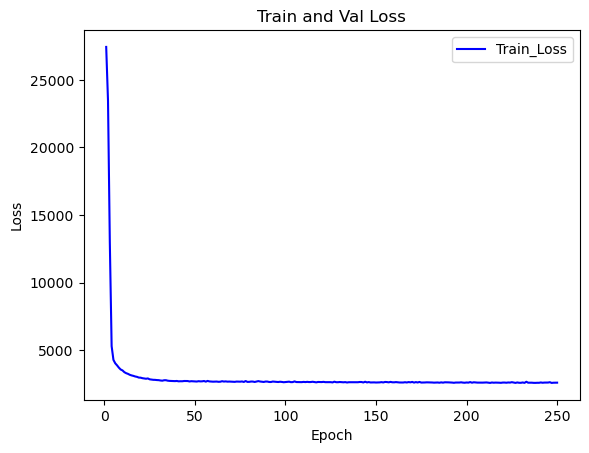

In [42]:
# 損失
plt.figure()
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_list, color='blue', linestyle="-", label='Train_Loss')
plt.legend()


#表示
plt.show()

## テストの実施

test 0 : prediction : 243.2   ground_truth : 152.0
test 1 : prediction : 80.1   ground_truth : 60.0
test 2 : prediction : 187.5   ground_truth : 48.0
test 3 : prediction : 194.5   ground_truth : 212.0
test 4 : prediction : 199.5   ground_truth : 178.0
test 5 : prediction : 250.1   ground_truth : 215.0
test 6 : prediction : 159.1   ground_truth : 179.0
test 7 : prediction : 114.5   ground_truth : 97.0
test 8 : prediction : 119.5   ground_truth : 67.0
test 9 : prediction : 260.1   ground_truth : 233.0
test 10 : prediction : 255.2   ground_truth : 346.0
test 11 : prediction : 128.6   ground_truth : 182.0
test 12 : prediction : 198.4   ground_truth : 129.0
test 13 : prediction : 279.1   ground_truth : 308.0
test 14 : prediction : 152.8   ground_truth : 245.0
test 15 : prediction : 128.1   ground_truth : 214.0
test 16 : prediction : 305.6   ground_truth : 270.0
test 17 : prediction : 131.5   ground_truth : 150.0
test 18 : prediction : 189.1   ground_truth : 52.0
test 19 : prediction : 176.4

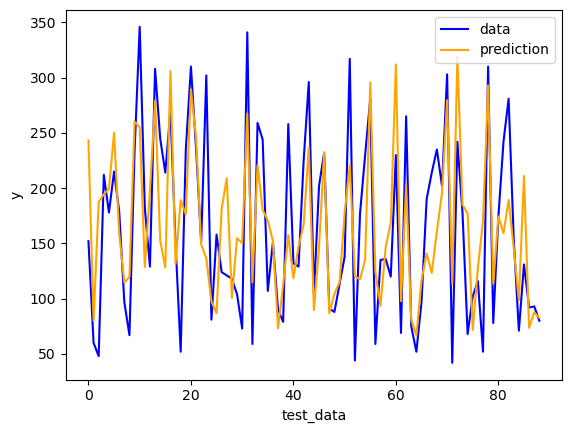

In [43]:
# ニューラルネットワークを評価モードに設定
net.eval()

count = 0

pred_list = []
label_list = []

for i in range(len(test_data)):
    data = torch.tensor(test_data[i], dtype=torch.float32)
    label = torch.tensor(test_label[i], dtype=torch.float32)


    data = data.to(device)
    label = label.to(device)

    y_pred_prob = net(data)
    pred = y_pred_prob.item()

    pred_list.append(pred)
    label_list.append(label.item())
    print(f"test {i} : prediction : {pred:.1f}   ground_truth : {label:.1f}")


# 損失
plt.figure()
plt.xlabel('test_data')
plt.ylabel('y')
plt.plot(range(len(test_data)), label_list, color='blue', linestyle="-", label='data')
plt.plot(range(len(test_data)), pred_list, color='orange', linestyle="-", label='prediction')
plt.legend()


#表示
plt.show()